# **fMNIST Classification with Dense Neural Networks (using Tensorflow)**

# **Problem Statement**
#### The objective of this report is to run a good EDA on fMNIST, train a neural network using Tensorflow, evaluate it using sklearn, and provide clear conclusions. 

## **Importing Libraries**

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split

# plotting modules
from matplotlib import pyplot as plt
import matplotlib.patches as patches  # for curved arrows

# cross validation functions
from sklearn.model_selection import cross_validate, cross_val_predict

# performance metrics
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, roc_auc_score,  classification_report, accuracy_score

from tensorflow.keras.datasets import fashion_mnist
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow as tf

## **Getting Data**

* Here we will use [Kaggle](https://www.kaggle.com/code/abhishekyana/fmnist-dataset-with-cnns-tensorflow/data) as our data repository. 
* Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples.Each example is a 28x28 grayscale image, associated with a label from 10 classes.
There are 10 different classes of images, as following:
0: T-shirt/top 
1: Trouser
2: Pullover
3: Dress
4: Coat
5: Sandal
6: Shirt
7: Sneakers
8: Bag
9: Ankle boot

In [2]:
train_df = np.genfromtxt('data/fashion-mnist_train.csv', dtype='uint8', delimiter=',', skip_header=1)

In [3]:
test_df = np.genfromtxt('data/fashion-mnist_test.csv', dtype='uint8', delimiter=',' , skip_header=1)

In [4]:
# Divide the data into training and testing sets.
X_train = train_df[:, 1:]
y_train = train_df[:, 0]

X_test = test_df[:, 1:]
y_test = test_df[:, 0]

## **Exploring the Data**

In [5]:
# Displays the data types and shapes of the training and test sets.
print(f'Image DType: {type(X_train)}')
print(f'Image Element DType: {type(X_train[0,0])}')
print(f'Label Element DType: {type(y_train[0])}')
print('**Shapes:**')
print('Train Data:')
print(f'Images: {X_train.shape}')
print(f'Labels: {y_train.shape}')
print('Test Data:')  

print(f'Images: {X_test.shape}')
print(f'Labels: {y_test.shape}')
print('Image Data Range:')
print(f'Min: {X_train.min()}')
print(f'Max: {X_train.max()}')

Image DType: <class 'numpy.ndarray'>
Image Element DType: <class 'numpy.uint8'>
Label Element DType: <class 'numpy.uint8'>
**Shapes:**
Train Data:
Images: (60000, 784)
Labels: (60000,)
Test Data:
Images: (10000, 784)
Labels: (10000,)
Image Data Range:
Min: 0
Max: 255


In [6]:
# Reshape and normalize the image data.
X_train = X_train.reshape((60000, 28 * 28))  
X_test = X_test.reshape((10000, 28 * 28))

X_train = X_train.astype("float32") / 255  
X_test = X_test.astype("float32") / 255  

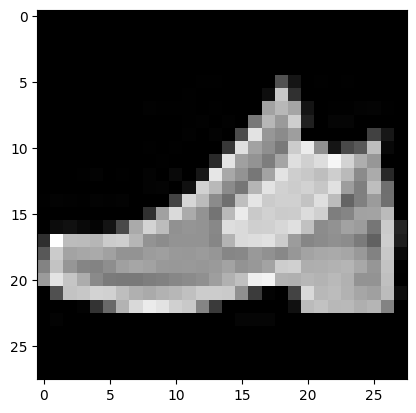

In [7]:
# Plot a sample image data
plt.imshow(X_train[1].reshape(28,28), cmap='gray')

In [8]:
# print the label associated with the image
print(f'Label: {y_train[1]}')

Label: 9


### **Visualize first 25 images to understand the structure and content of the dataset.**

Kaggle : [Reference](https://www.kaggle.com/code/kanikaw/mnist-nn-from-scratch?scriptVersionId=164122350&cellId=8)

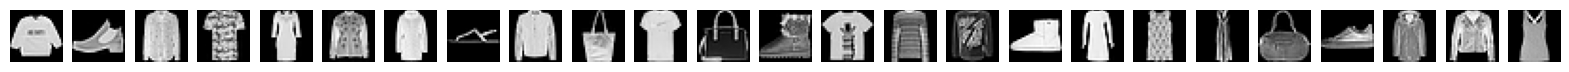

In [9]:
plt.figure(figsize=(20, 20))
for i in range(25):
    plt.subplot(1, 25, i + 1)
    plt.imshow(X_train[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()

Observations- 
- Each small image represents a different item of clothing or accessory from the Fashion MNIST dataset.
- The images are displayed in grayscale, with varying shades of gray to depict different features and textures.

### **Check class distribution**

Train set image class distribution    

Kaggle : [Reference](https://www.kaggle.com/code/gpreda/cnn-with-tensorflow-keras-for-fashion-mnist?scriptVersionId=66719946&cellId=13)

In [10]:
# Create a dictionary for each type of label 
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

def get_classes_distribution(data):
    label_counts = {}

    # Count the number of items in each class
    for label in data:
        if label in label_counts:
            label_counts[label] += 1
        else:
            label_counts[label] = 1

    # Get total number of samples
    total_samples = len(data)


    # Calculate percentage and display results
    for label, count in label_counts.items():
        percent = (count / total_samples) * 100
        print(f"{labels[label]:<20s}:   {count} or {percent:.2f}%")

get_classes_distribution(y_train)

Pullover            :   6000 or 10.00%
Ankle Boot          :   6000 or 10.00%
Shirt               :   6000 or 10.00%
T-shirt/top         :   6000 or 10.00%
Dress               :   6000 or 10.00%
Coat                :   6000 or 10.00%
Sandal              :   6000 or 10.00%
Bag                 :   6000 or 10.00%
Sneaker             :   6000 or 10.00%
Trouser             :   6000 or 10.00%


Plot the class distribution.    

Kaggle : [Reference](https://www.kaggle.com/code/fold10/exploring-mnist?scriptVersionId=129644281&cellId=4)

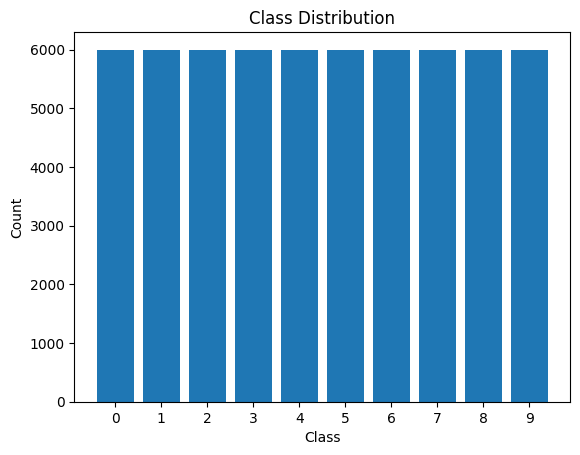

In [11]:
# Check for class imbalance in the mnist dataset
class_counts = np.bincount(y_train.astype(int))
plt.bar(np.arange(10), class_counts, tick_label=np.arange(10))
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution')
plt.show()

Observations : 
- The distribution of classes is  balanced

### **Explore pixel intensity distributions for a sample image**

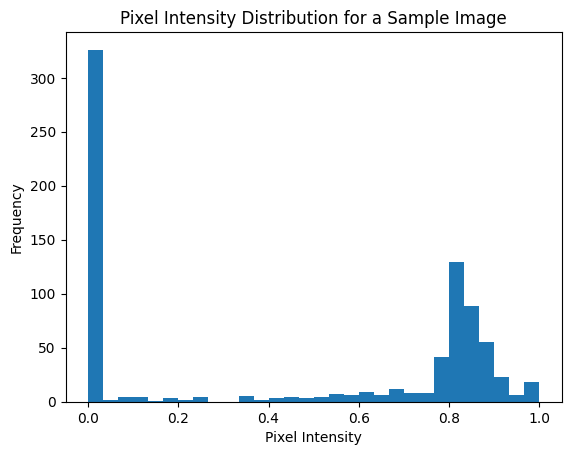

In [12]:
plt.hist(X_train[0], bins=30)
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.title('Pixel Intensity Distribution for a Sample Image')
plt.show()

Observations : 
- The histogram is skewed toward the left side, indicating that a significant number of pixels have low intensity (darker shades).
- There is a smaller peak around 0.8 pixel intensity, suggesting the presence of lighter pixels.

# **Define the model**

In [13]:
# Define a neural network model with 3 layers using the Keras Sequential API.
model = keras.Sequential([
    layers.Dense(128, activation="relu"), # neurons - 128. This layer processes the input data and applies the ReLU activation function to the weighted sum of inputs.
    layers.Dense(64, activation='relu'), # neurons - 64. Further processes the output from the first  layer.
    layers.Dense(10, activation="softmax") # neurons - 10 . Produces the final output probabilities for each class
])

## **Define the Loss Function, Optimizer and Metrics**

In [14]:
# Configure the neural network model for training 
model.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# **Data Split to Train, Test and Validation** 

In [15]:
# 20% of the training data will be used for validation in this case
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size= .2, random_state=42) 

In [16]:
print(f'Train_Images: {X_train.shape}')
print(f'Train_Labels: {y_train.shape}')
print(f'Val_Images: {X_val.shape}')
print(f'Val_Labels: {y_val.shape}')

Train_Images: (48000, 784)
Train_Labels: (48000,)
Val_Images: (12000, 784)
Val_Labels: (12000,)


## **Training ("Fitting") the model**

In [17]:
model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.5279 - accuracy: 0.8092
Epoch 2/10
1500/1500 [==============================] - 2s 1ms/step - loss: 0.3904 - accuracy: 0.8589
Epoch 3/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3604 - accuracy: 0.8717
Epoch 4/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3449 - accuracy: 0.8770
Epoch 5/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3321 - accuracy: 0.8819
Epoch 6/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3253 - accuracy: 0.8860
Epoch 7/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3180 - accuracy: 0.8894
Epoch 8/10
1500/1500 [==============================] - 2s 2ms/step - loss: 0.3098 - accuracy: 0.8928
Epoch 9/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.3050 - accuracy: 0.8936
Epoch 10/10
1500/1500 [==============================] - 3s 2ms/step - loss: 0.301

## **Model Evaluation on Validation Set**

In [18]:
test_loss, test_acc = model.evaluate(X_val, y_val)
print(f"test_acc: {test_acc}")

375/375 [==============================] - 0s 916us/step - loss: 0.4110 - accuracy: 0.8735
test_acc: 0.8734999895095825


In [19]:
# Predict classes using validation set
y_pred = model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)

375/375 [==============================] - 0s 1ms/step


In [20]:
def print_validation_report(y_true, y_pred):
    print("Classification Report")
    print(classification_report(y_true, y_pred))
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy of Validation Data: "+ str(accuracy))
    
    return accuracy

In [21]:
metrics  = print_validation_report(y_val, y_pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1232
           1       0.96      0.98      0.97      1174
           2       0.79      0.83      0.81      1200
           3       0.90      0.87      0.89      1242
           4       0.84      0.69      0.76      1185
           5       0.95      0.96      0.96      1141
           6       0.63      0.78      0.69      1243
           7       0.95      0.94      0.94      1224
           8       0.98      0.95      0.97      1149
           9       0.95      0.96      0.96      1210

    accuracy                           0.87     12000
   macro avg       0.88      0.87      0.88     12000
weighted avg       0.88      0.87      0.87     12000

Accuracy of Validation Data: 0.8735


In [22]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred_classes)
precision = precision_score(y_val, y_pred_classes, average='macro')
recall = recall_score(y_val, y_pred_classes, average='macro')
f1 = f1_score(y_val, y_pred_classes, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8735
Precision: 0.8811544454100494
Recall: 0.8746124687787651
F1 Score: 0.8761159341072373


Observations on Validation Set :
- The model achieved an accuracy of approximately 87.35% on the validation set.
- Model has achieved high precision and recall, which suggests that it can make accurate positive predictions while minimizing false negatives.
- F1 score of approximately 87.61% reflects a good balance between precision and recall.

## **Model Evaluation on Test Set**

In [23]:
# Predict classes using test set
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)

# Evaluate model performance on test set
test_accuracy = accuracy_score(y_test, y_test_pred_classes)
print("Test Accuracy:", test_accuracy)

313/313 [==============================] - 0s 1ms/step
Test Accuracy: 0.8826


In [24]:
metrics  = print_validation_report(y_test, y_test_pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.81      0.83      1000
           1       0.96      0.99      0.97      1000
           2       0.82      0.81      0.81      1000
           3       0.94      0.87      0.91      1000
           4       0.89      0.77      0.82      1000
           5       0.97      0.95      0.96      1000
           6       0.63      0.79      0.70      1000
           7       0.93      0.94      0.94      1000
           8       0.99      0.94      0.97      1000
           9       0.94      0.95      0.95      1000

    accuracy                           0.88     10000
   macro avg       0.89      0.88      0.88     10000
weighted avg       0.89      0.88      0.88     10000

Accuracy of Validation Data: 0.8826


In [25]:
# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_test_pred_classes)
precision = precision_score(y_test, y_test_pred_classes, average='macro')
recall = recall_score(y_test, y_test_pred_classes, average='macro')
f1 = f1_score(y_test, y_test_pred_classes, average='macro')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.8826
Precision: 0.8897421786193405
Recall: 0.8826
F1 Score: 0.8845233431946806


Observations on Validation Set :
- The model achieved an accuracy of approximately 88.26% on the test set which is slightly higher than the accuracy achieved for validation set.
- Considering the Precision, Recall and F1 score, the model’s performance on the test set is consistent with its performance on the validation set.

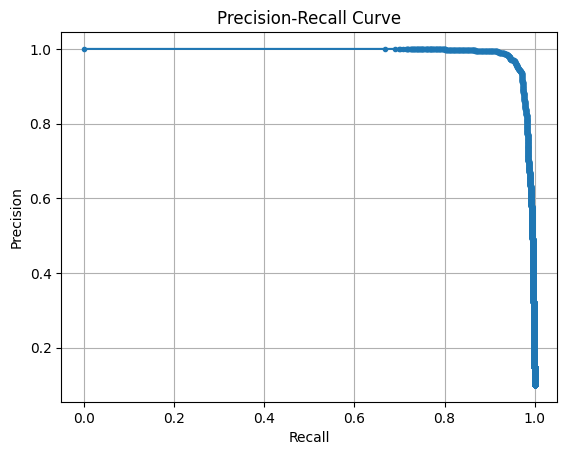

In [26]:
# Plot precision-recall curve based on the model’s predictions and the true labels for class 5
y_test_binary = (y_test == 5).astype(int)
precision, recall, thresholds = precision_recall_curve(y_test_binary, y_test_pred[:, int(5)])

# Plot precision-recall curve
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

Observations :
 - At the beginning of the curve (low recall values), the precision is very high (close to 1.0).
 - The curve shows a sharp drop in precision after approximately 0.8 recall.

## **Increase precision for class 5**

In [27]:
threshold = 0.8  # Adjust threshold to increase precision

# Convert probabilities to predicted class labels based on the new threshold
y_val_pred_class = ( y_test_pred[:, 5] > threshold).astype(int)

# Calculate precision after adjusting the threshold
precision_after_adjustment = precision_score(y_test_binary, y_val_pred_class)
print("Precision after adjustment:", precision_after_adjustment)

Precision after adjustment: 0.9842602308499475


## **Increase recall for class 5**

In [28]:
# Convert probabilities to predicted class labels based on the new threshold
y_val_pred_class = (y_test_pred[:, 5] > threshold).astype(int)

# Calculate recall after adjusting the threshold
recall_after_adjustment = recall_score(y_test_binary, y_val_pred_class)
print("Recall after adjustment:", recall_after_adjustment)

Recall after adjustment: 0.938


Observations : Increase threshold to 0.8 
- Before adjusting the threshold, the model had a precision of 0.97 and a recall of 0.95 for class 5.
- After changing the threshold to 0.8, the precision slighty increases to 0.98 while the recall drops slightly to 0.938.
- The higher threshold (0.8) led to increased precision but at the cost of reduced recall.